# Convolutional neural network

### Libraries and Variables

In [1]:
import torchvision
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as nnf
import numpy as np
import os
from torchinfo import summary

home_dir = os.path.expanduser('~')
raw_data_dir = os.path.join(home_dir, 'repos/DaNuMa2024/data/raw_data')
output_data_dir = os.path.join(home_dir, 'repos/DaNuMa2024/data/output_data')

### Overview

In this notebook, you will implement and train the simplest neural network architecture there is: a multilayer perceptron. You will see how it is able to solve non-linear function approximation problems. Also, you will demonstrate the advantage of validation during model training to prevent overfitting.\
Furthermore, the convolution layer will be introduced.

### Data

The CIFAR10 dataset is a well-known dataset for image classification. The torchvision library directly implements functionality for creating a torch dataset for this and many other standard datasets. For faster training, we only consider every 5th image by subsetting the original dataset. The inputs to a neural network are usually normalized. We use the training dataset to calculate the mean RGB value across all images and pixel values as well as their standard deviation. Then we define a transformation that normalizes input tensors with these values: $x_{norm} = (x - mean_x) / std_x$. \
We use the torchvision.transforms object which is a popular transformation tool for images that implements many transformations. What other transformations / augmentations could be added? Feel free to read the torchvision.transforms documentation and add further components to the augmentation pipeline!

In [14]:
# calculate normalization values
data_root = os.path.join(raw_data_dir, '4_convnet')
trainset = torchvision.datasets.CIFAR10(root=data_root, train=False, transform=torchvision.transforms.ToTensor())
every_fifth_idx = list(range(0, len(trainset), 5))
trainset = torch.utils.data.Subset(trainset, every_fifth_idx)

num_samples = trainset.dataset.data.shape[0]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=num_samples, 
                                            num_workers=2)
imgs, _ = next(iter(trainloader))
# the argument "dim" defines over which dimesions the mean and standard deviation of a tensor is calculated 
# In this case: dim 0=batch and dim (2, 3) = (height, width) --> we get the mean RGB value since the channel dimension is dim 1
dataset_mean = torch.mean(imgs, dim=(0, 2, 3))
dataset_std = torch.std(imgs, dim=(0, 2, 3))

normalized_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(dataset_mean, dataset_std)
])

With the normalize transform we just defined we can now instantiate the datasets and dataloaders.

In [15]:
# get train and validation set and dataloaders
trainset = torchvision.datasets.CIFAR10(root=data_root, train=True, transform=normalized_transform)
trainset = torch.utils.data.Subset(trainset, every_fifth_idx)
valset = torchvision.datasets.CIFAR10(root=data_root, train=False, transform=normalized_transform)
valset = torch.utils.data.Subset(valset, every_fifth_idx)

trainloader = DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=1000, shuffle=False, num_workers=2)

We use the same normalize transform for both the training and validation set. Why do we not use the validation set for the calculation of the normalization values?

######### YOUR ANSWER HERE:

Let's visualize 10 of the images to get an idea about what kind of dataset we are dealing with. When running the code as it is, you will get a warning that the pixels have unexpected values and the colors of the images look a little bit off. 
* Why is that the case? How can you transform the images to look normal again? Hint: Broadcasting might come in handy.
* What is the size of the images?

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])


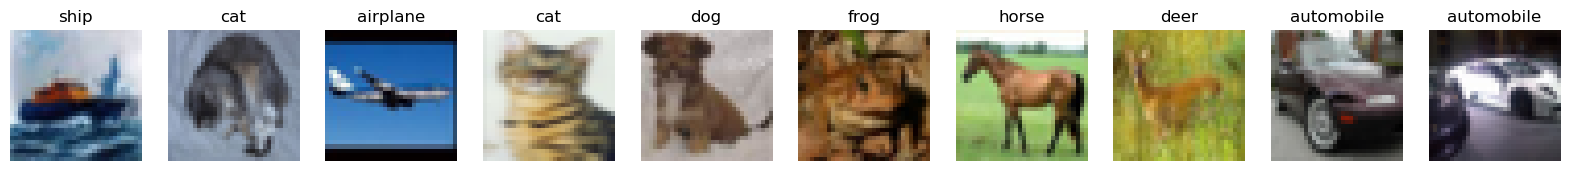

In [23]:
# visualize images from class
classes = trainset.dataset.classes
print(classes)
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
torch.manual_seed(0)

for ax in axs:
    # select random image from the batch
    batch = next(iter(trainloader))
    images, labels = batch
    random_idx = torch.randint(0, len(labels), (1,))
    image = images[random_idx].squeeze()
    label = labels[random_idx]

    ######### YOUR CODE HERE:
    image = image * dataset_std[:, None, None] + dataset_mean[:, None, None]
    print(image.shape[1:])
    
    # plot the image together with the class name
    class_name = classes[label]
    ax.set_title(class_name)
    ax.axis('off')
    ax.imshow(image.permute(1,2,0))

### MLP models

First, we will investigate how well MLPs are able to deal with the class prediction task. This is the MLP model taken from the solution of the MLP exercise. Images are high-dimensional inputs so we will naturally need bigger models (i.e. layer sizes and/or model depth) compared to the MLP exercise where we used one-dimensional data. However, using bigger models also increases the risk of overfitting because there are more neurons available with which the model can learn the inputs by heart! There are various possibilities to prevent overfitting such as *data augmentation*, *l2 regularization*, *using a validation set* or *dropout*. In this exercise, we will specifically explore

In [ ]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()

        modules = []
        for i in range(len(layer_sizes)-1):
            modules.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            if not i == len(layer_sizes)-2:
                modules.append(nn.ReLU())

        self.layers = nn.Sequential(*modules)


    def forward(self, x):
        return self.layers(x)

# training objects

In [4]:
def train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict=None):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    min_val_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_one_epoch(model, trainloader, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        if epoch % val_interval == 0:
            val_loss, val_accuracy = validate(model, valloader, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

        if savepath_best_statedict is not None:
            if val_loss < min_val_loss:
                torch.save(model.state_dict(), savepath_best_statedict)
                min_val_loss = val_loss
    return train_losses, val_losses, train_accuracies, val_accuracies

def train_one_epoch(model, trainloader, optimizer, device):
    model.train()
    total_loss = 0
    total_accuracy = 0
    for x_batch, y_batch in trainloader:
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.squeeze().long().to(device)
        y_pred = model(x_batch)
        pred_class = y_pred.argmax(dim=1)
        accuracy = (pred_class == y_batch).sum() / len(y_batch)

        optimizer.zero_grad()
        loss = nnf.cross_entropy(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += accuracy.item()
    return total_loss / len(trainloader), total_accuracy / len(trainloader)

def validate(model, valloader, device):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.squeeze().long().to(device)
            y_pred = model(x_batch)
            pred_class = y_pred.argmax(dim=1)
            accuracy = (pred_class == y_batch).sum() / len(y_batch)
            
            loss = nnf.cross_entropy(y_pred, y_batch)
            total_loss += loss.item()
            total_accuracy += accuracy.item()
    return total_loss / len(valloader), total_accuracy / len(valloader)

# MLP

In [113]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# model = MLP([3*32*32, 32, 64, 32, 10]).to(device)
model = MLP([3*32*32, 32, 32, 10]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
epochs = 10
val_interval = 1

train_losses, val_losses, train_accuracies, val_accuracies = train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict=None)

cuda


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:29<00:00,  2.90s/it]


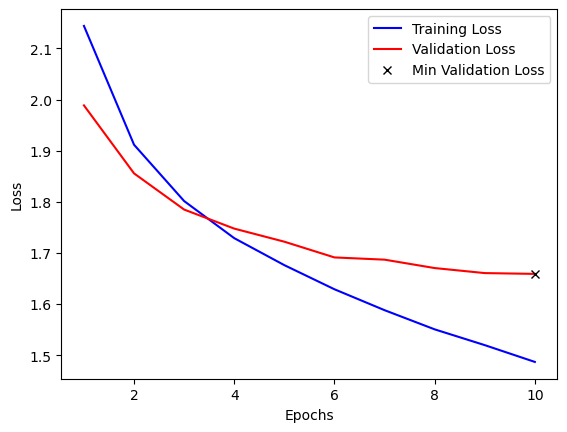

In [114]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_losses, c='blue', label='Training Loss')
plt.plot(np.linspace(1, epochs, epochs), val_losses, c='red', label='Validation Loss')

# Mark the minimum validation loss
index = np.argmin(val_losses)
plt.plot(index+1, val_losses[index], 'kx', label='Min Validation Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


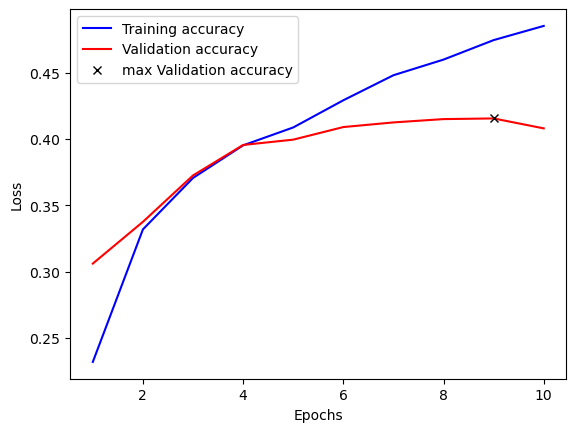

In [115]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_accuracies, c='blue', label='Training accuracy')
plt.plot(np.linspace(1, epochs, epochs), val_accuracies, c='red', label='Validation accuracy')

# Mark the minimum validation loss
index = np.argmax(val_accuracies)
plt.plot(index+1, val_accuracies[index], 'kx', label='max Validation accuracy')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# CONVNET

In [35]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='valid')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding='valid')
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='valid')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding='valid')
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='valid')
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(64)
        self.bn6 = nn.BatchNorm2d(64)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(64, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nnf.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nnf.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = nnf.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = nnf.relu(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = nnf.relu(x)
        # x = self.conv6(x)
        # x = self.bn6(x)
        # x = nnf.relu(x)
        x = self.avgpool(x)
        x = self.linear(x.squeeze())

        return x

In [ ]:
model = ConvNet()
summary(model, input_size=(1000, 3, 32, 32))

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = ConvNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
epochs = 20
val_interval = 1

train_losses, val_losses, train_accuracies, val_accuracies = train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict=None)

cuda


100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


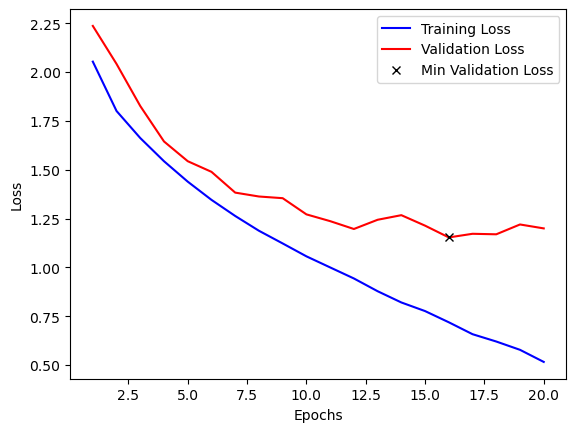

In [38]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_losses, c='blue', label='Training Loss')
plt.plot(np.linspace(1, epochs, epochs), val_losses, c='red', label='Validation Loss')

# Mark the minimum validation loss
index = np.argmin(val_losses)
plt.plot(index+1, val_losses[index], 'kx', label='Min Validation Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

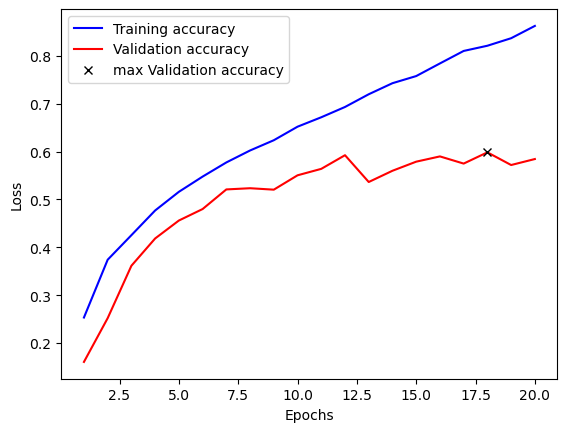

In [39]:

####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_accuracies, c='blue', label='Training accuracy')
plt.plot(np.linspace(1, epochs, epochs), val_accuracies, c='red', label='Validation accuracy')

# Mark the minimum validation loss
index = np.argmax(val_accuracies)
plt.plot(index+1, val_accuracies[index], 'kx', label='max Validation accuracy')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# experiment results

In [ ]:
import pandas as pd
test = pd.read_pickle('/usr/users/henrich1/repos/exercises_summer_school/exercises/convnet/experimental_results.pkl')
# test.iloc[test['min_val_loss'].argmin(), :]
test[test['layer_sizes'].apply(lambda x: x == [3072, 384, 384, 384, 10])]
print(test[test['dropout_ratio'].apply(lambda x: x == 0)]['max_val_acc'].max())
print(test[test['dropout_ratio'].apply(lambda x: x == 0.1)]['max_val_acc'].max())
print(test[test['dropout_ratio'].apply(lambda x: x == 0.3)]['max_val_acc'].max())
print(test[test['dropout_ratio'].apply(lambda x: x == 0.6)]['max_val_acc'].max())

In [21]:
test['max_val_acc'].argmax()

59

In [22]:
test.iloc[59]

dropout_ratio                                                     0.3
weight_decay                                                     0.01
layer_sizes                                 [3072, 384, 384, 384, 10]
min_val_loss                                                 1.501346
max_val_acc                                                     0.497
train_losses        [2.079287588596344, 1.8507863759994507, 1.7486...
val_losses          [1.8579891920089722, 1.7426167726516724, 1.674...
train_accuracies    [0.22840001434087753, 0.3337000161409378, 0.36...
val_accuracies      [0.3400000184774399, 0.37300002574920654, 0.41...
Name: 59, dtype: object

### further reads:

These reads require some understanding of mathematical notation. \
original dropout paper: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf \
There are many articles on regularization in neural networks in general. Here is one of them: https://www.pinecone.io/learn/regularization-in-neural-networks/